### Final Propensity matching results

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython


In [2]:
%reload_ext Cython

In [3]:
import sys
sys.path.append('..')
import warnings
def warn(message = None, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn

In [4]:
import scipy.stats as sts
import pandas as pd
import numpy as np
import time
import datetime as dt
from pathlib import Path
import time
#custom
from data_functions import make_date_to_MYR
from diabetes_onset import( process_canary,
get_tc, in_canary, diabet_onset, not_first_month_diabetes, 
                           match_data_per_month, 
                           filter_first_month_diabetes,
                           matched_population, 
                           propensity_func,
                           nearest_neighbor_func, 
                           random_matching_func, agglomerative )
import data_process
from tqdm import tqdm
from path import col_seq_can_all, col_seq_can 
from sklearn.neighbors import NearestNeighbors
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.random.seed(seed = 0)

In [5]:
# #setup cython
# #for cython build if needed -> cd to /modules folder and then run
# %cd ..
# !python3 setup.py build_ext --inplace
# %cd ./causal_data_creation/canary_application/

In [6]:
%config Completer.use_jedi = False

### Load pre matching data

In [7]:
# !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/CANARY_PAPER/DATA/Pre_Matching_DATA ./Pre_Matching_DATA --recursive;

In [8]:
# !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/CANARY_PAPER/DATA/tempHybridSelectionMoreData/random.p ./Pre_Matching_DATA/random.p;

In [9]:
pp_str = 'Pre_Matching_DATA/'

treated2 = pd.read_pickle(pp_str+'treated2.p')
controls = pd.read_pickle(pp_str+'controls.p')
pmpm =pd.read_pickle(pp_str+'pmpm.p')
random_controls = pd.read_pickle(pp_str+'random.p')

In [10]:
treated2.shape

In [11]:
controls.shape

In [12]:
pmpm.shape

# Transform data into latent space

In [13]:
import tensorflow as tf
from tensorflow.keras import models, layers
import warnings
warnings.filterwarnings('ignore')

model = models.load_model(pp_str+"TF_Latent_Model_m6_Canary_stacked_mse", compile=False)

/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type

In [14]:
onset = "CC_DIABETES"
cols_to_keep = ["PERS_ID", "MYR", 'AGE_AT_MIDMONTH', 'MBR_GNDR', onset]

In [15]:
latent_cols = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16']

In [16]:
%%time
#transform data of sick and healthy treated, and controls
tr2 = data_process.transform_features_with_NN(model, treated2[col_seq_can_all].copy(), cols_to_keep, latent_dim=16)
cntrls = data_process.transform_features_with_NN(model, controls[col_seq_can_all].copy(), cols_to_keep, latent_dim=16)
rndm = data_process.transform_features_with_NN(model, random_controls[col_seq_can_all].copy(), cols_to_keep, latent_dim=16)

CPU times: user 1min 43s, sys: 27.8 s, total: 2min 11s
Wall time: 1min 17s


### Pick Columns for matching

In [17]:
columns_to_match =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB']

all_columns1 = list(set(col for col in pmpm.columns)-set(['PERS_ID', 'MYR','MEDICAID_LOB',
                                                         'IP_BIN', 'ER_BIN', 'ACUTE', 'IP_C', 'ER_C', 'ACUTE_C','IP_BIN2', 'ER_BIN2']))

all_columns2 = list(set(all_columns1)-set(['IP_BIN6', 'ER_BIN6', 'LOB']))

In [18]:
%%time

#columns_to_match = columns_to_match + ['IP_BIN2', 'ER_BIN2']
#hier_cols = ['IP_BIN2', 'ER_BIN2', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6']
match_on = latent_cols
hier_cols = ['IP_BIN6', 'ER_BIN6']
hier_range = [1,1]
exact_match_dict = {'IP_BIN6':[0,1,2], 'ER_BIN6':[0,1,2], 'LOB':None}
nnr_func_args = {'match_on':match_on, 'hier_cols':None,
                        'hier_range':None, 'neighbors_per_treated': 5,
                 'onset': "CC_DIABETES", "onset_val" : 0, 'exact_match': False, 'exact_match_dict': None}
matched0, matched_data0 = matched_population(tr2.copy(), 
                                           cntrls.copy(),
                                           nearest_neighbor_func, 
                                           nnr_func_args)

Mathcing Function: nearest_neighbor_func
hERE
After filtering control ids are:328522 before they were:354792


1604it [25:59,  1.03it/s]

CPU times: user 38min 15s, sys: 25min 57s, total: 1h 4min 13s
Wall time: 26min 2s


####  In addition to the previously created matched groups create a random group

In [19]:
Path('./tempHierALL').mkdir(exist_ok = True)
p = './tempHierALL/'
matched_data0.to_pickle(p+'match0_l.p')
tr2.to_pickle(p+'treated0_l.p')

In [20]:
matched_data0_o = controls[controls.set_index(["PERS_ID", "MYR"]).index.isin(matched_data0.set_index(["PERS_ID", "MYR"]).index)].sort_values(by=["PERS_ID", "MYR"])

In [21]:
matched_data0_o.to_pickle(p+"match0_o.p")

In [22]:
rndm.to_pickle(p+"random_l.p")

In [23]:
pmpm2 = pmpm
try:
    pmpm2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
except:
    pass

In [24]:
from utils import statistics_first_month, p_val, stat_matrices 

### List containing all numerical columns

In [70]:
all_columns = list(set(col for col in pmpm.columns)-set(['PERS_ID', 'MYR','MEDICAID_LOB']))

### Stats First Month(Treated and Matched Controls)

In [26]:
%%time
tr_desc0, treated_first_month = statistics_first_month(treated2, all_columns, return_array = True)
con_desc0, controls_first_month = statistics_first_month(matched_data0_o, all_columns, return_array = True)

CPU times: user 3.76 s, sys: 39.2 ms, total: 3.8 s
Wall time: 3.8 s


### Stats First Month(General Pop and Random)

In [27]:
%%time
pmpm_desc = statistics_first_month(pmpm2, all_columns)
random_desc = statistics_first_month(random_controls, all_columns)

CPU times: user 2min 32s, sys: 7.62 s, total: 2min 40s
Wall time: 2min 40s


In [28]:
%%time
conds_first, full_first = stat_matrices(tr_desc0, con_desc0, pmpm_desc, random_desc, columns = columns_to_match)
conds_firstAllCols, full_firstAllCols = stat_matrices(tr_desc0, con_desc0, pmpm_desc, random_desc, columns = all_columns)

CPU times: user 25.1 ms, sys: 4.47 ms, total: 29.6 ms
Wall time: 27.8 ms


## Statistics on matching date

In [29]:
conds_first.round(3)

Treated Matched Controls Test-TC        General Population   Random
                    mean             mean  t-stat   pval               mean     mean
AGE_AT_MIDMONTH   50.206           50.184   0.061  0.952             44.311   47.606
ALLOW_AMT        693.750          681.162   0.217  0.828           1065.926  648.803
MBR_GNDR           0.206            0.211  -0.473  0.636              0.443    0.431
CC_TOBACCO         0.061            0.128  -7.588  0.000              0.074    0.098
CC_PRESSURE        0.001            0.003  -1.155  0.248              0.007    0.007
CC_OBESITY         0.456            0.298  12.401  0.000              0.109    0.228
CC_HYPERTENSION    0.325            0.259   5.372  0.000              0.208    0.249
CC_HYPOTHYROID     0.095            0.081   1.824  0.068              0.047    0.063
CC_DX_CNT          2.706            2.547   2.523  0.012              1.824    2.344
ACUTE2             0.039            0.049  -1.589  0.112              0.063    0.052
ACUTE6             0.112            0.148  -2.821  0.005              0.063    0.153
IP_BIN6            0.028            0.042  -2.073  0.038              0.021    0.047
ER_BIN6            0.089            0.115  -2.354  0.019              0.047    0.116
LOB                0.952            0.824  13.039  0.000              0.756    0.788

In [30]:
full_first

Treated                    Matched Controls                       Test-TC               General Population                         Test-TG                    Random                       Test-TR              
                       mean          std count             mean          std count     t-stat          pval               mean          std   count     t-stat          pval        mean          std count     t-stat          pval
AGE_AT_MIDMONTH   50.205736    12.733903  1604        50.184436    12.837650  7710   0.060542  9.517254e-01          44.310976    20.053585  356446  11.762030  6.207968e-32   47.606399    19.811819  7876   5.046484  4.583703e-07
ALLOW_AMT        693.750000  2216.211182  1604       681.161997  2086.071956  7710   0.217486  8.278342e-01        1065.926022  6933.418650  356446  -2.149328  3.160904e-02  648.802692  3166.090228  7876   0.542150  5.877276e-01
MBR_GNDR           0.205736     0.404364  1604         0.211025     0.408062  7710  -0.473023  6.362077e-01           0.442749     0.496712  356446 -19.081951  3.914644e-81    0.431056     0.495255  7876 -17.097185  1.439342e-64
CC_TOBACCO         0.061097     0.239583  1604         0.127626     0.333695  7710  -7.588142  3.556931e-14           0.074202     0.262100  356446  -1.998705  4.564109e-02    0.098400     0.297874  7876  -4.714462  2.458070e-06
CC_PRESSURE        0.001247     0.035300  1604         0.002853     0.053345  7710  -1.154686  2.482487e-01           0.007390     0.085645  356446  -2.871419  4.086576e-03    0.006602     0.080991  7876  -2.598386  9.380812e-03
CC_OBESITY         0.456359     0.498247  1604         0.298184     0.457490  7710  12.401352  4.854844e-35           0.108841     0.311440  356446  44.434357  0.000000e+00    0.228035     0.419592  7876  19.209513  1.041149e-80
CC_HYPERTENSION    0.324813     0.468451  1604         0.259403     0.438336  7710   5.372136  7.968654e-08           0.207717     0.405674  356446  11.525694  9.915163e-31    0.249365     0.432673  7876   6.274847  3.652926e-10
CC_HYPOTHYROID     0.094763     0.292979  1604         0.080934     0.272751  7710   1.823550  6.825211e-02           0.047300     0.212281  356446   8.916454  4.836392e-19    0.063484     0.243847  7876   4.516264  6.370084e-06
CC_DX_CNT          2.706359     2.227360  1604         2.547471     2.308543  7710   2.522978  1.165308e-02           1.824419     2.412274  356446  14.614465  2.345498e-48    2.343702     2.439688  7876   5.504457  3.799632e-08
ACUTE2             0.038653     0.208377  1604         0.048508     0.229450  7710  -1.589222  1.120442e-01           0.063258     0.243426  356446  -4.041413  5.314111e-05    0.051549     0.237733  7876  -2.020160  4.339483e-02
ACUTE6             0.111596     0.412699  1604         0.148119     0.483057  7710  -2.821444  4.790917e-03           0.063258     0.243426  356446   7.901966  2.753095e-15    0.153377     0.475791  7876  -3.274968  1.060534e-03
IP_BIN6            0.028055     0.199403  1604         0.041894     0.251463  7710  -2.072639  3.823333e-02           0.020587     0.141996  356446   2.097153  3.598074e-02    0.046851     0.263725  7876  -2.701482  6.915408e-03
ER_BIN6            0.088529     0.359723  1604         0.114786     0.415583  7710  -2.353617  1.861241e-02           0.047286     0.212251  356446   7.732311  1.058846e-14    0.116176     0.402957  7876  -2.548765  1.082613e-02
LOB                0.951995     0.213843  1604         0.823995     0.380849  7710  13.039256  1.589411e-38           0.755775     0.429627  356446  18.281467  1.257397e-74    0.787836     0.408866  7876  15.649481  1.606802e-54

### Statistics Over all dates (treated, controls)

In [31]:
%%time
tr_desc0A = treated2[all_columns].describe().loc[['mean', 'std', 'count']].T
tr_desc0A['count'] = tr_desc0A['count'].astype(int)

con_desc0A = matched_data0_o[all_columns].describe().loc[['mean', 'std', 'count']].T
con_desc0A['count'] = con_desc0A['count'].astype(int)

CPU times: user 784 ms, sys: 0 ns, total: 784 ms
Wall time: 784 ms


### Statistics Over all dates (general population, Random)

In [32]:
%%time
pmpm_descA = pmpm2[all_columns].describe().loc[['mean', 'std', 'count']].T
pmpm_descA['count'] = pmpm_descA['count'].astype(int)

random_descA = random_controls[all_columns].describe().loc[['mean', 'std', 'count']].T
random_descA['count'] = random_descA['count'].astype(int)

CPU times: user 30 s, sys: 2.48 s, total: 32.5 s
Wall time: 32.5 s


In [33]:
%%time
conds, full = stat_matrices(tr_desc0A, con_desc0A, pmpm_descA, random_descA, columns = columns_to_match)
conds_AllCols, full_AllCols = stat_matrices(tr_desc0A, con_desc0A, pmpm_descA, random_descA, columns = all_columns)

CPU times: user 29.7 ms, sys: 0 ns, total: 29.7 ms
Wall time: 27.9 ms


In [34]:
conds.round(3)

Treated Matched Controls Test-TC        General Population   Random
                    mean             mean  t-stat   pval               mean     mean
AGE_AT_MIDMONTH   50.837           51.054  -2.528  0.011             50.379   50.236
ALLOW_AMT        782.435          806.871  -0.853  0.393            857.856  706.609
MBR_GNDR           0.189            0.195  -2.198  0.028              0.433    0.429
CC_TOBACCO         0.063            0.127 -29.293  0.000              0.102    0.100
CC_PRESSURE        0.002            0.004  -4.557  0.000              0.013    0.008
CC_OBESITY         0.505            0.339  50.429  0.000              0.255    0.286
CC_HYPERTENSION    0.325            0.281  14.204  0.000              0.329    0.300
CC_HYPOTHYROID     0.095            0.092   1.778  0.075              0.078    0.075
CC_DX_CNT          2.918            2.833   5.135  0.000              2.955    2.759
ACUTE2             0.032            0.047  -9.916  0.000              0.060    0.050
ACUTE6             0.100            0.143 -13.974  0.000              0.168    0.150
IP_BIN6            0.025            0.042 -10.835  0.000              0.055    0.049
ER_BIN6            0.079            0.109 -11.200  0.000              0.122    0.111
LOB                0.953            0.824  52.826  0.000              0.802    0.803

#### Distribution Plots For Treated and Matched Controls
1)  Sick(S) Treated versus  Sick Control groups  
2) Healthy(H) Treated versus Healthy Control Groups

### Matrices and Figures for the paper

In [35]:
columns_to_match

['AGE_AT_MIDMONTH',
 'ALLOW_AMT',
 'MBR_GNDR',
 'CC_TOBACCO',
 'CC_PRESSURE',
 'CC_OBESITY',
 'CC_HYPERTENSION',
 'CC_HYPOTHYROID',
 'CC_DX_CNT',
 'ACUTE2',
 'ACUTE6',
 'IP_BIN6',
 'ER_BIN6',
 'LOB']

In [36]:
mapping = dict(zip(columns_to_match, ['Age', 'Total Cost', 'Gender', 'Tobacco Use', 'Pressure', 'Obesity', 
                                     'Hypertension', 'Hypothyroid', 'Disease Count','Acute Care 2 Months', 'Acute Care 6 Months',
                                      'Inpatient Visits 6 Months', 'Emergency Vistits 6 Months', 'Line of Bussiness']))
mapping2 = dict(zip(all_columns, all_columns))
#mapping = dict(zip(columns_to_match, columns_to_match))
new_names = list(mapping.values())

In [37]:
base_path =  './results/hier_matching_ALL/'
p = Path(base_path)
p.mkdir(parents = True, exist_ok = True)

In [38]:
import matplotlib as mpl
sns.set_context(context = 'paper')
mpl.style.use('seaborn-paper')

In [39]:
from diabetes_onset_plotter import plot_hist, save_arrays, save_arrays2


#### remove %%capture to see output

In [40]:
%%capture

dist_plot_args = {'hist':True}
axes = plot_hist(treated_first_month.copy(), 
                 controls_first_month.copy(), mapping2, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = base_path+'figures/distributions_all/',
                dist_plot_args = dist_plot_args)

In [41]:
%%capture
dist_plot_args = {'hist':True}
axes = plot_hist(treated_first_month.copy(), 
                 controls_first_month.copy(), mapping, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = base_path+'figures/distributions_selection/',
                dist_plot_args = dist_plot_args)

### Save enhanced stats arrays(these will be used at the end)
Arrays with: Statistics in first day, statistics  in the span of monthsm statistiocs from selected columns and all columns

In [42]:
arrays = [conds_first, full_first, conds_firstAllCols, full_firstAllCols,
         conds, full, conds_AllCols, full_AllCols]
names = ['conds_first', 'full_first', 'conds_firstAllCols', 'full_firstAllCols',
         'conds', 'full', 'conds_AllCols', 'full_AllCols']
save_arrays2(arrays, names, base_path+'tables/stats/')

# Latent Space Stat

In [43]:
latent_cols

['x1',
 'x2',
 'x3',
 'x4',
 'x5',
 'x6',
 'x7',
 'x8',
 'x9',
 'x10',
 'x11',
 'x12',
 'x13',
 'x14',
 'x15',
 'x16']

In [44]:
%%time
tr_desc0_l, treated_first_month_l = statistics_first_month(tr2, latent_cols, return_array = True)
con_desc0_l, controls_first_month_l = statistics_first_month(matched_data0, latent_cols, return_array = True)

CPU times: user 2.82 s, sys: 20.5 ms, total: 2.84 s
Wall time: 2.85 s


In [45]:
pmpm_lat = data_process.transform_features_with_NN(model, pmpm[col_seq_can_all].copy(), cols_to_keep, latent_dim=16)

In [46]:
%%time
pmpm_desc_l = statistics_first_month(pmpm_lat, latent_cols)
random_desc_l = statistics_first_month(rndm, latent_cols)

CPU times: user 1min 51s, sys: 1.14 s, total: 1min 52s
Wall time: 1min 52s


In [47]:
%%time
conds_first_latent, full_first_latent = stat_matrices(tr_desc0_l, con_desc0_l, pmpm_desc_l, random_desc_l, columns = latent_cols)

CPU times: user 15.5 ms, sys: 0 ns, total: 15.5 ms
Wall time: 14.5 ms


In [48]:
conds_first_latent

Treated Matched Controls   Test-TC           General Population     Random
          mean             mean    t-stat      pval               mean       mean
x1  -23.822917       -23.503219 -0.155292  0.876595         -44.713254 -26.118523
x2   23.744400        23.429656  0.155058  0.876779          44.380419  26.021895
x3  -24.649667       -24.322183 -0.155125  0.876726         -46.094808 -27.007852
x4  -19.063797       -18.839028 -0.129594  0.896891         -38.999364 -21.838662
x5   11.947792        11.852477  0.076926  0.938684          29.105553  15.053039
x6  -15.680181       -15.516846 -0.109671  0.912673         -34.225559 -18.605027
x7  -25.775903       -25.433665 -0.153862  0.877722         -48.506657 -28.325218
x8  -22.487424       -22.188060 -0.155574  0.876372         -42.046000 -24.614238
x9   23.740579        23.423868  0.154904  0.876900          44.506736  26.041410
x10  26.027095        25.682728  0.154197  0.877458          48.783001  28.560991
x11 -20.068558       -19.832563 -0.131361  0.895493         -40.577726 -22.891081
x12  20.356972        20.111616  0.134401  0.893089          40.907011  23.077863
x13 -22.577532       -22.275773 -0.154876  0.876922         -42.376687 -24.770448
x14  22.009919        21.715554  0.154484  0.877231          41.421171  24.171772
x15  22.169132        21.881231  0.154066  0.877561          41.307775  24.296895
x16 -24.992617       -24.658409 -0.155169  0.876692         -46.848090 -27.394448

In [49]:
full_first_latent

Treated                  Matched Controls                    Test-TC           General Population                       Test-TG               Random                     Test-TR          
          mean        std count             mean        std count    t-stat      pval               mean         std   count    t-stat      pval       mean         std count    t-stat      pval
x1  -23.822917  78.741435  1604       -23.503219  74.217653  7710 -0.155292  0.876595         -44.713254  250.282663  356446  3.342101  0.000832 -26.118523  113.359993  7876  0.773888  0.439016
x2   23.744400  77.639239  1604        23.429656  73.177467  7710  0.155058  0.876779          44.380419  246.793986  356446 -3.348084  0.000814  26.021895  111.779426  7876 -0.778643  0.436209
x3  -24.649667  80.744297  1604       -24.322183  76.107163  7710 -0.155125  0.876726         -46.094808  256.635304  356446  3.345935  0.000820 -27.007852  116.243222  7876  0.775266  0.438202
x4  -19.063797  66.124635  1604       -18.839028  62.574108  7710 -0.129594  0.896891         -38.999364  208.080278  356446  3.836195  0.000125 -21.838662   94.962953  7876  1.116433  0.264265
x5   11.947792  46.857548  1604        11.852477  44.785073  7710  0.076926  0.938684          29.105553  142.298690  356446 -4.827868  0.000001  15.053039   66.874818  7876 -1.773104  0.076244
x6  -15.680181  56.618653  1604       -15.516846  53.766995  7710 -0.109671  0.912673         -34.225559  176.229431  356446  4.213646  0.000025 -18.605027   81.141083  7876  1.376973  0.168553
x7  -25.775903  85.058176  1604       -25.433665  80.192493  7710 -0.153862  0.877722         -48.506657  270.226762  356446  3.368141  0.000757 -28.325218  122.432447  7876  0.795721  0.426214
x8  -22.487424  73.617696  1604       -22.188060  69.366920  7710 -0.155574  0.876372         -42.046000  234.124794  356446  3.344990  0.000823 -24.614238  106.021260  7876  0.766639  0.443315
x9   23.740579  78.190815  1604        23.423868  73.710571  7710  0.154904  0.876900          44.506736  248.462865  356446 -3.346567  0.000818  26.041410  112.550596  7876 -0.781217  0.434694
x10  26.027095  85.398678  1604        25.682728  80.516634  7710  0.154197  0.877458          48.783001  271.269897  356446 -3.358902  0.000783  28.560991  122.908022  7876 -0.787839  0.430810
x11 -20.068558  68.512649  1604       -19.832563  64.811261  7710 -0.131361  0.895493         -40.577726  215.836017  356446  3.804760  0.000142 -22.891081   98.426641  7876  1.095679  0.273247
x12  20.356972  69.644810  1604        20.111616  65.852305  7710  0.134401  0.893089          40.907011  219.542726  356446 -3.747977  0.000178  23.077863  100.056730  7876 -1.039022  0.298821
x13 -22.577532  74.513002  1604       -22.275773  70.242901  7710 -0.154876  0.876922         -42.376687  236.770452  356446  3.348297  0.000813 -24.770448  107.255931  7876  0.781331  0.434627
x14  22.009919  72.873278  1604        21.715554  68.695561  7710  0.154484  0.877231          41.421171  231.592870  356446 -3.356087  0.000791  24.171772  104.907456  7876 -0.787515  0.431000
x15  22.169132  71.477338  1604        21.881231  67.367451  7710  0.154066  0.877561          41.307775  227.199104  356446 -3.372947  0.000744  24.296895  102.919305  7876 -0.790084  0.429498
x16 -24.992617  82.375762  1604       -24.658409  77.648819  7710 -0.155169  0.876692         -46.848090  261.786025  356446  3.342864  0.000829 -27.394448  118.580028  7876  0.774047  0.438922

In [50]:
conds_first_latent.to_csv('./results/hier_matching_ALL/tables/stats/conds_first_latent.csv', index=True, header=True)

In [51]:
full_first_latent.to_csv('./results/hier_matching_ALL/tables/stats/full_first_latent.csv', index=True, header=True)

# Standardized Means Graph

In [58]:
tr_desc0, treated_first_month = statistics_first_month(treated2, columns_to_match, return_array = True)

In [59]:
con_desc0, controls_first_month = statistics_first_month(matched_data0_o, columns_to_match, return_array = True)

In [60]:
un_controls_ = controls[columns_to_match].describe().loc[['mean', 'std', 'count']].T

In [75]:
un_controls_all = controls[all_columns].describe().loc[['mean', 'std', 'count']].T

In [76]:
un_controls_all.to_csv("unmatched_all_cols_stats.csv", index=True, header=True)

In [64]:
len(controls)

In [65]:
pooled = (tr_desc0['std']* 1604 + un_controls_['std']*len(controls))/(1604+len(controls))

In [66]:
stdMeans = pd.DataFrame()
stdMeans['Treated'] = tr_desc0['mean']/pooled
stdMeans['Controls'] = un_controls_['mean']/pooled
stdMeans['MControls'] = con_desc0['mean']/pooled

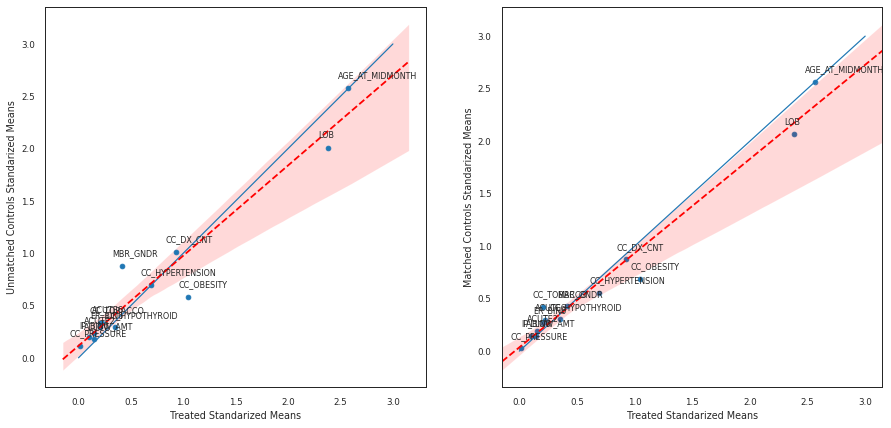

In [67]:
fig, ax = plt.subplots(1,2, figsize = (15,7))
ax[0].plot([0,3], [0, 3])
ax[1].plot([0,3], [0, 3])
ax[0].set_xlabel('Treated Standarized Means')
ax[0].set_ylabel('Unmatched Controls Standarized Means')
sns.regplot(stdMeans['Treated'].values, stdMeans['Controls'].values,scatter = False, ax = ax[0],line_kws={"color": "red","linestyle" : '--'
})

ax[0].scatter(stdMeans['Treated'], stdMeans['Controls'])
ax[1].scatter(stdMeans['Treated'], stdMeans['MControls'])
ax[1].set_xlabel('Treated Standarized Means')
ax[1].set_ylabel('Matched Controls Standarized Means')
sns.regplot(stdMeans['Treated'].values, stdMeans['MControls'].values, scatter = False,ax = ax[1], line_kws={"color": "red","linestyle" : '--'
})
for i, name in enumerate(list(stdMeans.index)):
    ax[0].annotate(name, (stdMeans['Treated'].iloc[i],stdMeans['Controls'].iloc[i]), fontsize = 'small',
                   textcoords = 'offset points',xytext = (-10,10))
    ax[1].annotate(name, (stdMeans['Treated'].iloc[i],stdMeans['MControls'].iloc[i]),fontsize = 'small',
                   textcoords = 'offset points', xytext = (-10,10))

fig.show()

# Ratio Stats

In [77]:
disease_cols = [cols for cols in treated2.columns if "CC" in cols and cols!='CC_DX_CNT']
other_binary_cols = ['MBR_GNDR', 'LOB', 'PREGNANCY', 'IP_BIN', 'ER_BIN', 'ACUTE']
binary_cols = other_binary_cols + disease_cols 
restricted_cols = ['PERS_ID', 'MYR', 'MEDICAID_LOB']
continuous_cols = [cols for cols in treated2.columns if cols not in binary_cols + restricted_cols]

In [78]:
def calculate_continuous_d(t, c):
    Xt = np.mean(t)
    Xc = np.mean(c)
    St = np.std(t)
    Sc = np.std(c)
    d = np.abs((Xt-Xc)/(np.sqrt((St**2 + Sc**2)/2)))
    return d

In [79]:
def calculate_binary_d(t, c):
    Pt = np.mean(t)
    Pc = np.mean(c)
    d = np.abs((Pt-Pc)/(np.sqrt((Pt*(1-Pt)+Pc*(1-Pc))/2)))
    return d

In [80]:
d_metric_before = pd.DataFrame()
for col in treated2.columns.tolist():
    if col not in restricted_cols:
        if col in binary_cols:
            d = calculate_binary_d(treated2[[col]].values, controls[[col]].values)
        elif col in continuous_cols:
            d = calculate_continuous_d(treated2[[col]].values, controls[[col]].values)
        d_metric_before.loc[0,col] = d

In [83]:
d_metric_before.T.to_csv("d_metric_before.csv", header=True, index=True)

In [93]:
d_metric_before.T[d_metric_before.T[0]<0.1].size

64

In [99]:
d1 = d_metric_before.loc[:,:'LOB']

In [100]:
d1.T[d1.T[0]<0.1].size

56

In [84]:
d_metric_after = pd.DataFrame()
for col in treated2.columns.tolist():
    if col not in restricted_cols:
        if col in binary_cols:
            d = calculate_binary_d(treated2[[col]].values, matched_data0_o[[col]].values)
        elif col in continuous_cols:
            d = calculate_continuous_d(treated2[[col]].values, matched_data0_o[[col]].values)
        d_metric_after.loc[0,col] = d

In [86]:
d_metric_after.T.to_csv("d_metric_after.csv", header=True, index=True)

In [94]:
d_metric_after.T[d_metric_after.T[0]<0.1].size

80

In [101]:
d2 = d_metric_after.loc[:,:'LOB']

In [102]:
d2.T[d2.T[0]<0.1].size

68

In [87]:
ratio = d_metric_after/d_metric_before
ratio

MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  ALLOW_ER  ALLOW_IP   CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS    CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR    CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER  CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  CC_OSTEOPOROSIS  \
0  0.027561         0.620402    0.34556  0.039649   0.49907  1.713845      0.447785           0.498889  0.678095   0.848001             0.299094      0.258004   0.436139       0.059081   0.458579    3.060761  0.189587          0.543254     1.049655           0.254618           0.011391              0.893601  0.37753            0.148685       0.282009                  0.72044           0.267819     0.355314         0.499623   2.416968               0.737519     1.228004         3.662353     0.273871           0.149701          0.162212             NaN              0.946924                0.542296               1.23363                0.855964                    0.802835         2.29875             NaN          0.822327         0.674031            0.86795        12.898503        0.202249      0.593406      0.02456         0.08782       6.76942  0.182006        0.543472      0.33903            0.563119               0.642263               1.248341    0.635112         1.143379   

   CC_PERIPHERAL  CC_PERSONALITY  CC_PRESSURE  CC_PROSTATE_CANCER   CC_PTSD  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR       LOB  PREGNANCY    IP_BIN    ER_BIN     ACUTE      IP_C      ER_C   ACUTE_C   IP_BIN6   ER_BIN6    ACUTE6   IP_BIN2   ER_BIN2    ACUTE2  
0       0.281566        3.100985     0.278891            0.290281  1.759534          0.764759                0.894696        0.879433         0.415847   0.134204    1.567353            2.019119          0.361516  0.879515   0.753284  0.518737  0.552692  0.537746  2.875514  1.420203  1.973129  0.632549  0.707614  0.669446  0.548968  0.584451  0.567239

In [91]:
ratio.T[ratio.T[0]>=1.0].size

19

In [89]:
ratio.T.to_csv("ratio.csv", header=True, index=True)